# <center> Stack Overflow Question Tagging Model <center>

## <center> Data Wrangling & EDA <center>

### Objective:
Develop a machine learning model to automatically assign tags to questions posted on a forum platform like StackOverflow or Quora, based on the question's text content.

Kaggle Link: https://www.kaggle.com/stackoverflow/stacksample

### Data Description:
The dataset comprises 10% of the questions and answers from the Stack Overflow programming Q&A website, organized into three tables:

1. Questions: Contains the title, body, creation date, closed date (if applicable), score, and owner ID for non-deleted Stack Overflow questions whose ID is a multiple of 10.
    
    Answers: Includes the body, creation date, score, and owner ID for each answer to the questions in the Questions table. The ParentID column links back to the Questions table.

2. Tags: Contains the tags associated with each question in the Questions table.

### Machine Learning Problem Category:

   - Advanced Natural Language Processing (NLP)
   - Multi-label Text Classification
   - Predictive Modeling

### Tasks:

Identify relevant tags from the text content of questions.
Predict the voting behavior (upvoted, downvoted, or closed) of questions based on their text.
Predict the response time for answering questions.

### Approach:

1. Preprocess the text data by tokenization, removing stop words, and stemming/lemmatization.
2. Convert text data into numerical representations using techniques like TF-IDF or word embeddings.
3. Train multi-label classification models to predict relevant tags for questions.
4. Utilize regression models to predict voting behavior and response time based on text features.
5. Evaluate model performance using appropriate metrics such as accuracy, F1-score, and mean squared error.

### Expected Outcome:
An automated tagging system that accurately assigns relevant tags to questions, predicts their voting behavior, and estimates the time required for answering, thereby enhancing the efficiency of question handling on online forum platforms.

## 1.0 Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


#suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Show plots inline
%matplotlib inline

In [2]:
os.getcwd()

'/Users/nahom/Data_Science/StackoverflowTagClassificationDeck'

In [3]:
# List of filenames containing the paths to the CSV files to be read
filenames = ['../StackoverflowTagClassificationDeck/data/Answers.csv',
             '../StackoverflowTagClassificationDeck/data/Questions.csv',
             '../StackoverflowTagClassificationDeck/data/Tags.csv']

# Initialize an empty list to store DataFrames
dfs=[]

# Loop through each filename
for f in filenames:
    # Read the CSV file into a DataFrame and append it to the list
    dfs.append(pd.read_csv(f, encoding="ISO-8859-1"))

In [4]:
# Assign the first DataFrame (Answers) from the list to a variable
df_answers = dfs[0]

# Assign the second DataFrame (Questions) from the list to a variable
df_questions = dfs[1]

# Assign the third DataFrame (Tags) from the list to a variable
df_tags = dfs[2]

In [5]:
df_answers.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."


In [6]:
df_questions.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [7]:
df_tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [8]:
# Print the number of rows in each DataFrame
print("Number of rows in Questions DataFrame:", df_questions.shape[0])
print("Number of rows in Answers DataFrame:", df_answers.shape[0])
print("Number of rows in Tags DataFrame:", df_tags.shape[0])

Number of rows in Questions DataFrame: 1264216
Number of rows in Answers DataFrame: 2014516
Number of rows in Tags DataFrame: 3750994


In [9]:
# Count the number of unique IDs in the 'Id' column of the Questions DataFrame
df_questions['Id'].nunique()

1264216

In [10]:
# Drop the specified columns from the Answers DataFrame and rename the remaining columns
df_answers.drop(columns=['Id','OwnerUserId', 'CreationDate'], inplace=True)
df_answers.columns = ['Id', 'A_Score', 'A_Body']


   - #### Merge ```question``` and ```answer``` dataframes using ```left``` join to get all answers mapped to a given question.

In [11]:
# Merge the Answers and Questions DataFrames on the 'Id' column
df = pd.merge(df_answers, df_questions, how='left', on='Id')

# Display the first 4 rows of the merged DataFrame
df.head()


,Id,A_Score,A_Body,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers...",58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
1,80,12,<p>I wound up using this. It is a kind of a ha...,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
2,180,1,<p>I've read somewhere the human eye can't dis...,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
3,260,4,"<p>Yes, I thought about that, but I soon figur...",91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...
4,260,28,"<p><a href=""http://www.codeproject.com/Article...",91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [12]:
# Print the number of unique IDs and the total number of rows in the DataFrame
print(df.Id.nunique(), df.shape[0])


1102568 2014516


- #### Merge tags associated to a given ```Id``` to output tags by unique ```Id```.

In [13]:
# Convert the 'Tag' column to string type
df_tags['Tag'] = df_tags['Tag'].astype(str)

# Group the tags by 'Id' and concatenate them into a single string separated by commas
df_tags = df_tags.groupby('Id')['Tag'].apply(', '.join).reset_index()


In [14]:
df_tags.shape[0]

1264216

- Merge Q&A merged dataframe at prior step and updated ```Tag``` dataframe from prior step using ```inner``` join to get all answers mapped to a given question ```AND``` associated tags

In [15]:
# Merge the merged DataFrame with the DataFrame containing tags based on the 'Id' column
df_merged = pd.merge(df, df_tags, how='inner', on='Id')

# Display the first 4 rows of the merged DataFrame
df_merged.head()


,Id,A_Score,A_Body,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Tag
0,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers...",58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"svn, tortoisesvn, branch, branching-and-merging"
1,80,12,<p>I wound up using this. It is a kind of a ha...,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"flex, actionscript-3, air"
2,180,1,<p>I've read somewhere the human eye can't dis...,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"algorithm, language-agnostic, colors, color-space"
3,260,4,"<p>Yes, I thought about that, but I soon figur...",91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"c#, .net, scripting, compiler-construction"
4,260,28,"<p><a href=""http://www.codeproject.com/Article...",91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"c#, .net, scripting, compiler-construction"


In [16]:
df_merged.shape[0]

2014516

## 2.0 Exploratory Data Anaylsis 

### 2.0 Data Definition 

In [17]:
df_merged.head()

,Id,A_Score,A_Body,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Tag
0,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers...",58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"svn, tortoisesvn, branch, branching-and-merging"
1,80,12,<p>I wound up using this. It is a kind of a ha...,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"flex, actionscript-3, air"
2,180,1,<p>I've read somewhere the human eye can't dis...,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"algorithm, language-agnostic, colors, color-space"
3,260,4,"<p>Yes, I thought about that, but I soon figur...",91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"c#, .net, scripting, compiler-construction"
4,260,28,"<p><a href=""http://www.codeproject.com/Article...",91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"c#, .net, scripting, compiler-construction"


In [18]:
# Display concise summary of the merged DataFrame including column data types and non-null values
df_merged.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2014516 entries, 0 to 2014515
Data columns (total 10 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Id            int64  
 1   A_Score       int64  
 2   A_Body        object 
 3   OwnerUserId   float64
 4   CreationDate  object 
 5   ClosedDate    object 
 6   Score         int64  
 7   Title         object 
 8   Body          object 
 9   Tag           object 
dtypes: float64(1), int64(3), object(6)
memory usage: 153.7+ MB


### 2.1 Count of unique values or codes by 'Tag' column

In [19]:
df_merged.Tag.value_counts()

Tag
java                                            15959
javascript, jquery                              14906
php                                             14138
android                                         14108
javascript                                      13387
                                                ...  
php, variables, include, require                    1
jquery, multi-select, selectable                    1
android, gridview, fragment, custom-adapter         1
wpf, xaml, datagrid, rowdetailstemplate             1
cpu, intel, cpu-architecture, flops, nehalem        1
Name: count, Length: 594790, dtype: int64

In [20]:
# Calculate the percentage of unique tags in the merged DataFrame
(df_merged['Tag'].nunique() / df_merged['Tag'].size) * 100

29.525206054456753

### 2.2 Range of values per column

- Min, max values for numeric datatype columns

In [21]:
# Calculate the minimum and maximum values for each column in the DataFrame
df_merged.select_dtypes(include=[np.number]).agg([min,max]).T

,min,max
Id,80.0,40143190.0
A_Score,-42.0,5718.0
OwnerUserId,1.0,7046594.0
Score,-73.0,5190.0


In [22]:
# Describe the numeric columns in the DataFrame
df_merged._get_numeric_data().describe()

,Id,A_Score,OwnerUserId,Score
count,2.014516e+06,2.014516e+06,1.982623e+06,2.014516e+06
mean,1.808390e+07,2.480563e+00,1.815046e+06,5.675192e+00
std,1.169152e+07,1.590938e+01,1.700506e+06,4.671622e+01
min,8.000000e+01,-4.200000e+01,1.000000e+00,-7.300000e+01
25%,7.692900e+06,0.000000e+00,4.400300e+05,0.000000e+00
50%,1.712404e+07,1.000000e+00,1.236022e+06,1.000000e+00
75%,2.804977e+07,2.000000e+00,2.787211e+06,3.000000e+00
max,4.014319e+07,5.718000e+03,7.046594e+06,5.190000e+03


### 2.3 Find the count and proportion of null values across all columns

In [23]:
# Count the number of missing values in each column and sort them in descending order
df_merged.isnull().sum().sort_values(ascending=False)

ClosedDate      1915448
OwnerUserId       31893
Id                    0
A_Score               0
A_Body                0
CreationDate          0
Score                 0
Title                 0
Body                  0
Tag                   0
dtype: int64

In [24]:
# Calculate the percentage of missing values in each column and filter out columns with missing values
nas = pd.DataFrame(df_merged.isnull().sum().sort_values(ascending=False) / len(df_merged), columns=['percent'])
pos = nas['percent'] > 0
nas[pos]

,percent
ClosedDate,0.950823
OwnerUserId,0.015832


In [25]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2014516 entries, 0 to 2014515
Data columns (total 10 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Id            int64  
 1   A_Score       int64  
 2   A_Body        object 
 3   OwnerUserId   float64
 4   CreationDate  object 
 5   ClosedDate    object 
 6   Score         int64  
 7   Title         object 
 8   Body          object 
 9   Tag           object 
dtypes: float64(1), int64(3), object(6)
memory usage: 153.7+ MB


### 2.4 Data Cleaning 

- Drop duplicates if exist

In [26]:
# Remove duplicate rows from the DataFrame
df_merged = df_merged.drop_duplicates()

In [27]:
df_merged.shape[0]

2014512

In [28]:
# Count the number of missing values in each column and sort them in descending order
df_merged.isnull().sum().sort_values(ascending = False)

ClosedDate      1915444
OwnerUserId       31893
Id                    0
A_Score               0
A_Body                0
CreationDate          0
Score                 0
Title                 0
Body                  0
Tag                   0
dtype: int64

### 2.5 Delete irrelevant variables

In [29]:
# Remove 'OwnerUserId' and 'ClosedDate' columns from the DataFrame
df_merged.drop(columns=['OwnerUserId', 'ClosedDate'], inplace=True)

In [30]:
df_merged.dtypes

Id               int64
A_Score          int64
A_Body          object
CreationDate    object
Score            int64
Title           object
Body            object
Tag             object
dtype: object

### 2.6 Rename Question Score and Body column names

In [31]:
# Rename columns 'Body' to 'Q_Body', 'Score' to 'Q_Score', and 'CreationDate' to 'CreationYear'
df_merged.rename(columns={'Body':'Q_Body', 'Score':'Q_Score', 'CreationDate':'CreationYear'}, inplace=True)

# Print the number of rows and information about the DataFrame
print(df_merged.shape[0], df_merged.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2014512 entries, 0 to 2014515
Data columns (total 8 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   Id            int64 
 1   A_Score       int64 
 2   A_Body        object
 3   CreationYear  object
 4   Q_Score       int64 
 5   Title         object
 6   Q_Body        object
 7   Tag           object
dtypes: int64(3), object(5)
memory usage: 138.3+ MB
2014512 None


In [32]:
# Reorder columns to 'Id', 'CreationYear', 'Title', 'Q_Body', 'Tag', 'Q_Score', 'A_Body', 'A_Score'
columnsTitles = ['Id', 'CreationYear', 'Title', 'Q_Body', 'Tag', 'Q_Score', 'A_Body', 'A_Score']
df_merged = df_merged.reindex(columns=columnsTitles)

In [33]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2014512 entries, 0 to 2014515
Data columns (total 8 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   Id            int64 
 1   CreationYear  object
 2   Title         object
 3   Q_Body        object
 4   Tag           object
 5   Q_Score       int64 
 6   A_Body        object
 7   A_Score       int64 
dtypes: int64(3), object(5)
memory usage: 138.3+ MB


In [34]:
df_merged.shape[0]

2014512

In [35]:
df_merged.isnull().sum()

Id              0
CreationYear    0
Title           0
Q_Body          0
Tag             0
Q_Score         0
A_Body          0
A_Score         0
dtype: int64

Before proceeding with missing value handling, we need to ```Pre-process``` the text data, which involves:

- Converting all letters to either lower or upper case.
- Eliminating punctuations, specifically HTML tags (markdowns) that appear in each question when a developer posts queries.
- Eliminating stop words, sparse terms, and specific words.
- Removing excess whitespaces, including leading and trailing spaces.
- Applying stemming using the NLTK library.
- Removing records where the question title is less than 10 characters long.

In [36]:
# Downloading NLTK stopwords and punkt tokenizer
stop_words = stopwords.words('english')
nltk.download('stopwords')
nltk.download('punkt')

# Initializing Porter stemmer
stemmer = PorterStemmer()


[nltk_data] Downloading package stopwords to /Users/nahom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/nahom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [37]:
def remove_punctuation(s):
    """
    Remove punctuation from a string.

    Args:
    s (str): Input string.

    Returns:
    str: String with punctuation removed.
    """
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    return s

In [38]:
def clean_text(text):
    """
    Clean the text by performing various substitutions.

    Args:
    text (str): Input text.

    Returns:
    str: Cleaned text.
    """
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    return text

In [39]:
# Convert titles to lowercase
df_merged['Title'] = df_merged['Title'].str.lower()

# Remove punctuation from titles
df_merged['Title'] = df_merged['Title'].apply(remove_punctuation)

# Remove stop words from titles
df_merged['Title'] = df_merged['Title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Stem words in titles
df_merged['Title'] = df_merged['Title'].apply(lambda x: stemmer.stem(x))

# Clean text in titles using custom function
df_merged['Title'] = df_merged['Title'].apply(lambda x: clean_text(x))


In [40]:
# Filter out records with title length less than 15 characters
df_merged = df_merged[df_merged['Title'].str.len() >= 15]

In [41]:
# Display a random sample of 10 titles from the dataframe
df_merged['Title'].sample(10)

695329                                    concepts oop class
347770                 map routes according following schema
360870         dynamically adding new tables datacontext edm
1376462                          entity framework 6 filter t
1743669    use angular2 html binding jade specifically ar...
196591                          create activex control com c
319026     ios development whats easy way generate unlock...
626396                                getting 2 elements xml
414629     regular expression remove html tags string python
12104                     xp best way synchronize files fold
Name: Title, dtype: object

In [42]:
# Get the number of rows in the dataframe
df_merged.shape[0]

1980409

### 2.7 Identify any anomalies and outliers
- Create boxplot
- Create histogram of 'numeric' variables

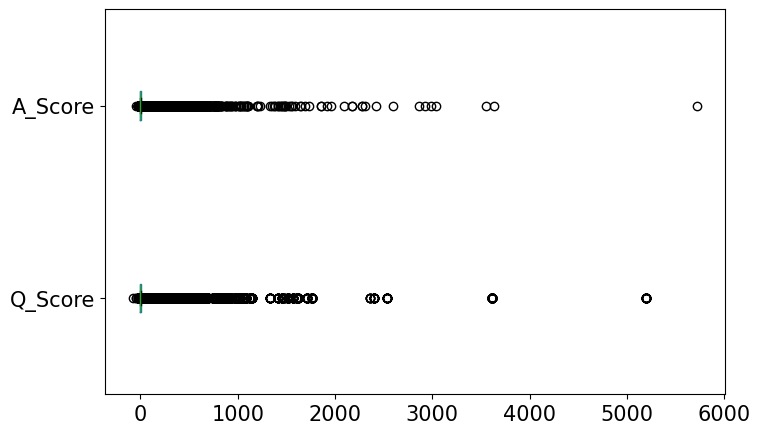

In [43]:
# Create a boxplot for numerical columns in the dataframe
f, ax = plt.subplots(figsize=(8, 5))

# Select numerical columns and drop the 'Id' column
df_num = df_merged.select_dtypes(include=np.number)
df_num = df_num.drop(['Id'], axis=1)

# Plot the boxplot
boxplot = df_num.boxplot(grid=False, vert=False, fontsize=15)

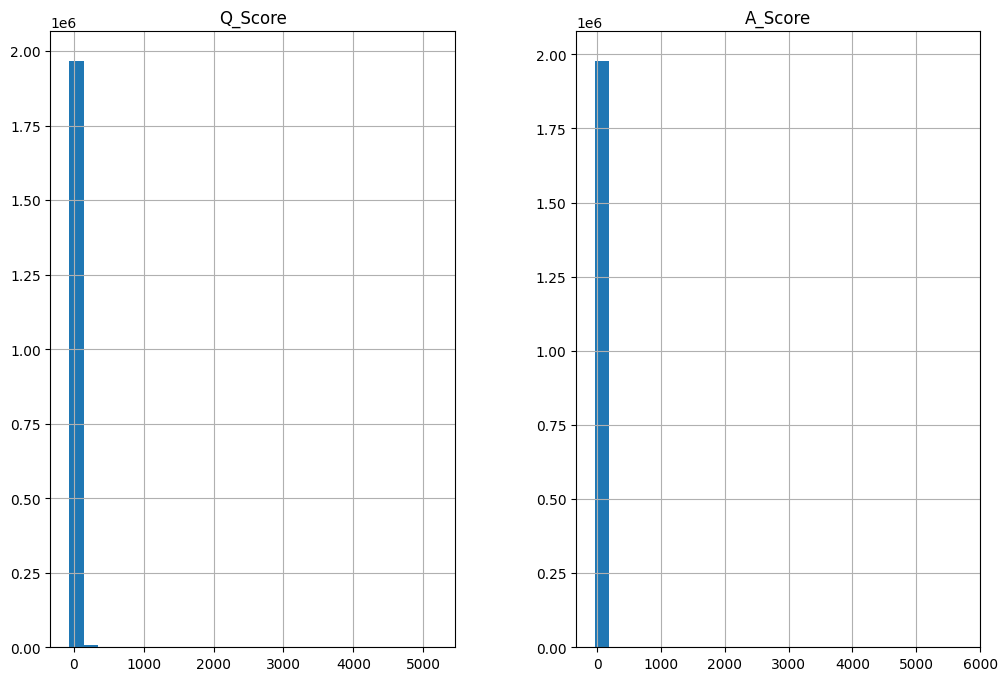

In [44]:
# Plot histograms for numerical columns in the dataframe
df_num.hist(bins=25, figsize=(12, 8));

In [45]:
# Display descriptive statistics for the 'Q_Score' and 'A_Score' columns
df_num[['Q_Score', 'A_Score']].describe()

,Q_Score,A_Score
count,1.980409e+06,1.980409e+06
mean,5.627585e+00,2.465003e+00
std,4.675182e+01,1.586115e+01
min,-7.300000e+01,-4.200000e+01
25%,0.000000e+00,0.000000e+00
50%,1.000000e+00,1.000000e+00
75%,3.000000e+00,2.000000e+00
max,5.190000e+03,5.718000e+03


### 2.8 Remove outliers from Answer and Question scores to normalise plot

In [46]:
# Outlier removal using the Interquartile Range (IQR) method
# Reference: https://stackoverflow.com/questions/50461349/how-to-remove-outlier-from-dataframe-using-iqr

# Selecting the 'Q_Score' and 'A_Score' columns for outlier removal
stepframe = df_merged[['Q_Score', 'A_Score']]

# Calculating the first quartile (Q1), third quartile (Q3), and Interquartile Range (IQR)
Q1 = stepframe.quantile(0.25)
Q3 = stepframe.quantile(0.75)
IQR = Q3 - Q1

# Removing outliers using the IQR method and calculating the number of remaining rows
df = stepframe[~((stepframe < (Q1 - 1.5 * IQR)) | (stepframe > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape[0]

1701432

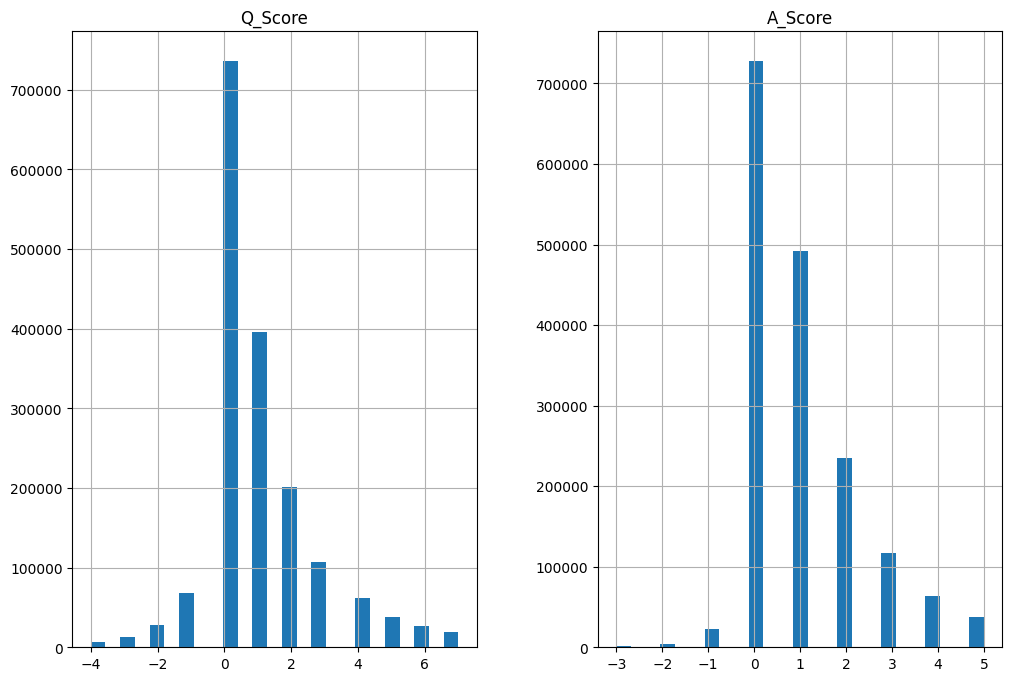

In [47]:
# Histogram plot after outlier removal using the Interquartile Range (IQR) method
df_iqr = df
df_iqr.hist(bins=25, figsize=(12, 8));

In [48]:
# Concatenating the DataFrame with outliers removed (df_iqr) and the original DataFrame (df_merged)
# This ensures that only the rows without outliers are kept, maintaining data integrity
df_no_outliers = pd.concat([df_iqr, df_merged], axis=1, join='inner')

# Displaying the number of rows in the DataFrame after outlier removal
df_no_outliers.shape[0]


1701432

In [49]:
df_no_outliers.columns

Index(['Q_Score', 'A_Score', 'Id', 'CreationYear', 'Title', 'Q_Body', 'Tag',
       'Q_Score', 'A_Body', 'A_Score'],
      dtype='object')

In [50]:
# Removing any duplicated columns in the DataFrame to ensure data consistency
df_no_outliers = df_no_outliers.loc[:, ~df_no_outliers.columns.duplicated()]

# Displaying the column names after removing any duplicates
df_no_outliers.columns

Index(['Q_Score', 'A_Score', 'Id', 'CreationYear', 'Title', 'Q_Body', 'Tag',
       'A_Body'],
      dtype='object')

### 2.9 To prevent redundant exploratory data analysis (EDA) on duplicated question attributes such as ```Title```, ```Tags```, and ```Q_Body```, generate a new dataframe whenever EDA is required for these attributes.

In [51]:
# Remove duplicate rows based on the 'Id' column to ensure unique questions
# Keep the first occurrence of each unique question and drop subsequent duplicates
df_no_outliers_unique_q = df_no_outliers.drop_duplicates(subset=['Id'], keep=False)

# Print the columns and shape (number of rows and columns) of the dataframe
print(df_no_outliers_unique_q.columns, df_no_outliers_unique_q.shape[0])

Index(['Q_Score', 'A_Score', 'Id', 'CreationYear', 'Title', 'Q_Body', 'Tag',
       'A_Body'],
      dtype='object') 589261


In [52]:
df_no_outliers_unique_q.shape[0]

589261

### 3.0 Bar chart of most popular tags - single OR combination (in descending order)

In [53]:
# Center output (plots) in the notebook
# This HTML code adjusts the display style of PNG outputs in Jupyter notebooks to center them.
# It ensures that figures generated by Matplotlib are displayed in the center of the cell.
# Source: https://moonbooks.org/Articles/How-to-center-a-matplotlib-figure-in-a-Jupyter-notebook-/

from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


In [54]:
df_no_outliers_unique_q.head()

,Q_Score,A_Score,Id,CreationYear,Title,Q_Body,Tag,A_Body
303,0,2,8940,2008-08-12T15:04:29Z,vmware server linux secondary nic connect,<p>With VMWare Server running under Linux (Deb...,"linux, vmware, sysadmin, nic",<p>I believe you can set the desired solution ...
493,2,3,12720,2008-08-15T20:42:51Z,add net 20 sp1 prerequisite deployment project,<p>I have a .NET 2.0 application that has rece...,".net-2.0, installer, dependencies",<p>You'll want to setup launch condition in yo...
588,0,2,14570,2008-08-18T13:21:45Z,organize dataset queries improve perform,<p>I don't know when to add to a dataset a tab...,"asp.net, database, performance",<blockquote>\n <p>Should I just do it when I'...
601,5,3,11430,2008-08-14T18:08:00Z,version net framework ships sql server 2008,<p>Does SQL Server 2008 ship with the .NET 3.5...,"sql-server, sql-server-2008","<p>I swear this isn't being pedantic, but is a..."
634,0,3,15900,2008-08-19T08:46:08Z,entity diagrams aspnet mvc,<p>What's the best way/tool to display nice di...,"asp.net, asp.net-mvc, .net-3.5, graphics, diagram",<p>Here are some 3rd-party diagramming tools:<...


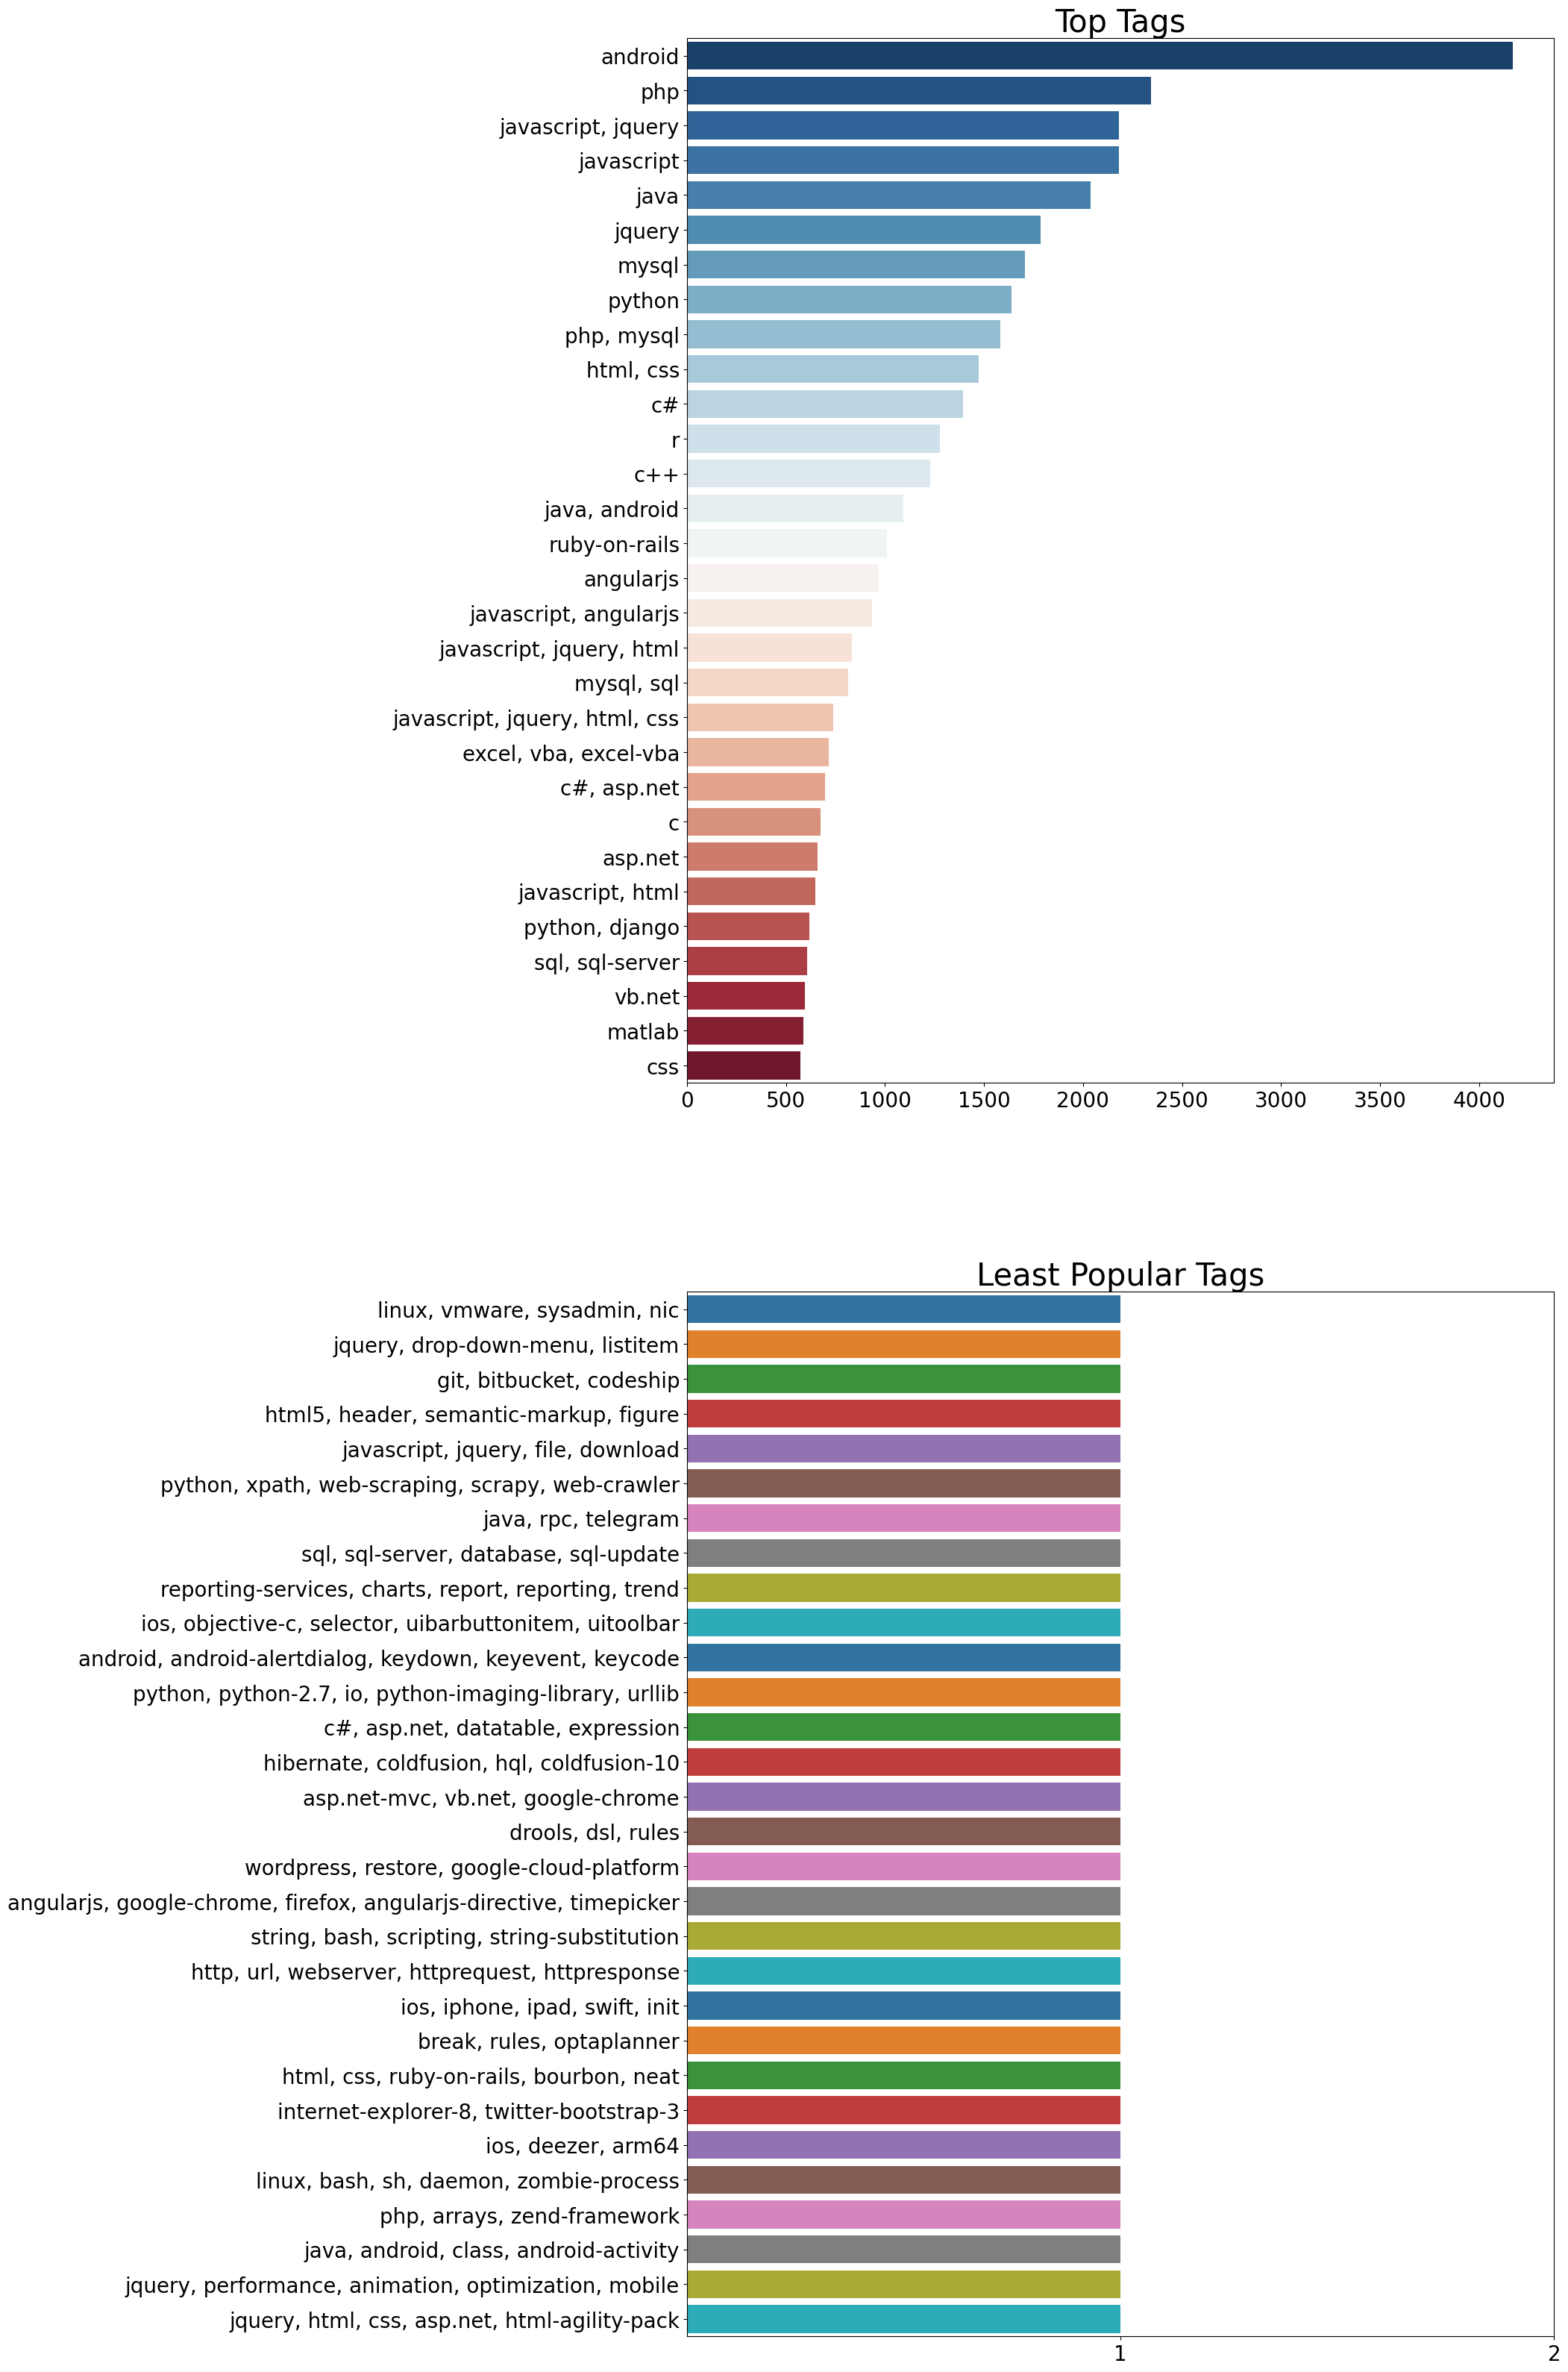

In [55]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 40))

# In the following brackets, we want the value_counts() of the 'Tags' 
x = pd.DataFrame(df_no_outliers_unique_q.Tag.value_counts())
y = pd.DataFrame(df_no_outliers_unique_q.Tag.value_counts(ascending=True))

# Get the tag names by calling list() on the index of the DataFrame
names_desc = list(x.index[:30])
names_asc = list(y.index[:30])

# Get the values by accessing the values of the DataFrame directly
values_desc = list(x.values[:30].flatten())
values_asc = list(y.values[:30].flatten())

sns.barplot(x=values_desc, y=names_desc, palette="RdBu_r", ax=ax[0])
ax[0].set_title("Top Tags", fontsize=30)
ax[0].tick_params(labelsize=20)

sns.barplot(x=values_asc, y=names_asc, palette="tab10", ax=ax[1])
ax[1].set_title("Least Popular Tags", fontsize=30)
ax[1].set_xticks([1, 2])  # Adjust x-axis ticks for better readability
ax[1].tick_params(labelsize=20)


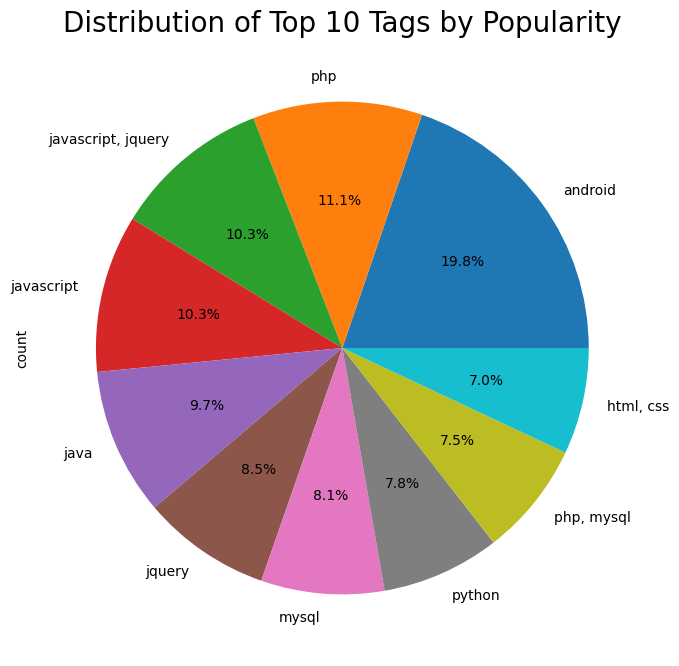

In [56]:
# Plotting the distribution of the top 10 tags by popularity using a pie chart
df_no_outliers_unique_q['Tag'].value_counts().head(10).plot(kind='pie', figsize=(8, 8), autopct='%1.1f%%')

# Adding title to the plot
plt.title("Distribution of Top 10 Tags by Popularity", fontsize=20)

# Display the plot
plt.show()

### Conclusion - Android rules in terms of developer community support based on questions posted.

### 3.1 Explore data relationships

Text(0.5, 1.0, 'Heat Map of Variables')

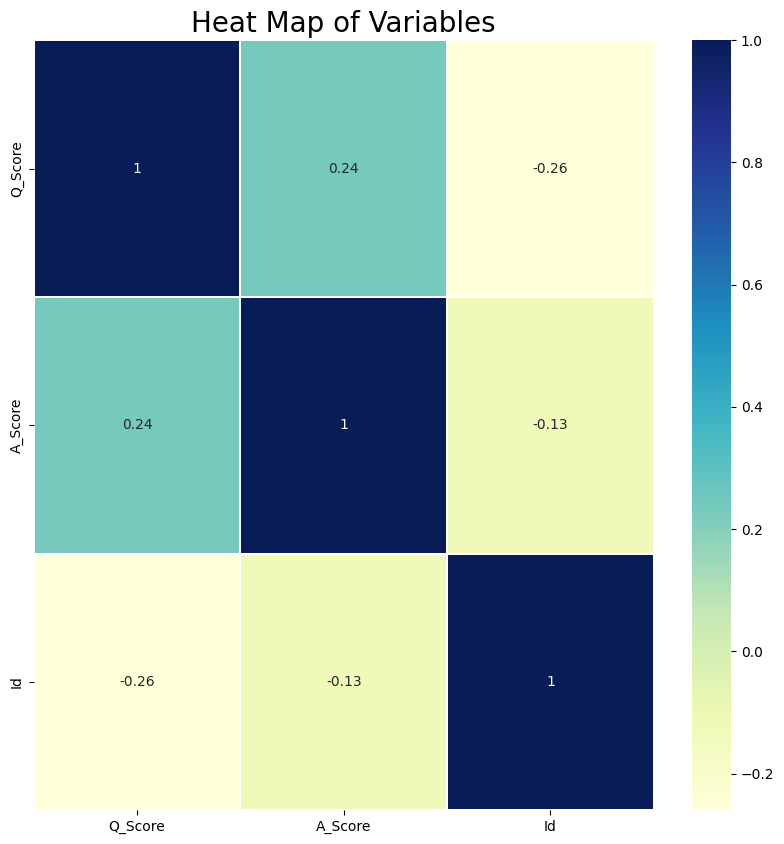

In [57]:
# Select only numeric columns
numeric_columns = df_no_outliers.select_dtypes(include=np.number)

# Calculate the correlation coefficients between numeric columns
corr = numeric_columns.reset_index(drop=True).corr().round(2)

# Set the figure size for the heatmap
plt.figure(figsize=(10, 10))

# Plot the heatmap
sns.heatmap(corr, linewidths=.1, cmap="YlGnBu", annot=True)

# Add title to the heatmap
plt.title("Heat Map of Variables", fontsize=20)


### Conclusion - There is no strong correlation between question and answer scores

### 3.2 Q&A: Upvotes vs Downvotes

In [58]:
# Calculate the length of the 'A_Score' column in the DataFrame 'df_no_outliers'.
len(df_no_outliers['A_Score'])

1701432

In [59]:
# Calculate the length of the 'Q_Score' column in the DataFrame df_no_outliers_unique_q
len(df_no_outliers_unique_q['Q_Score'])

589261

In [60]:
# Count the occurrences of each unique value in the 'Q_Score' column of the DataFrame 'df_no_outliers_unique_q'.
df_no_outliers_unique_q['Q_Score'].value_counts()

Q_Score
 0    305714
 1    136977
 2     55610
-1     24886
 3     24444
 4     12110
-2      9716
 5      6454
-3      4283
 6      4055
 7      2720
-4      2292
Name: count, dtype: int64

In [61]:
# Calculate the number of downvotes and upvotes for questions and answers
Q_downvotes = len(df_no_outliers_unique_q[df_no_outliers_unique_q['Q_Score'] < 0])
Q_upvotes = len(df_no_outliers_unique_q[df_no_outliers_unique_q['Q_Score'] > 0])
A_downvotes = len(df_no_outliers[df_no_outliers['A_Score'] < 0])
A_upvotes = len(df_no_outliers[df_no_outliers['A_Score'] > 0])

# Print the results
print("Downvotes and Upvotes for questions are: {} and {}".format(Q_downvotes, Q_upvotes))
print("Downvotes and Upvotes for answers are: {} and {}".format(A_downvotes, A_upvotes))

Downvotes and Upvotes for questions are: 41177 and 242370
Downvotes and Upvotes for answers are: 28367 and 944780


Text(0.5, 1.0, 'Question vs Answers')

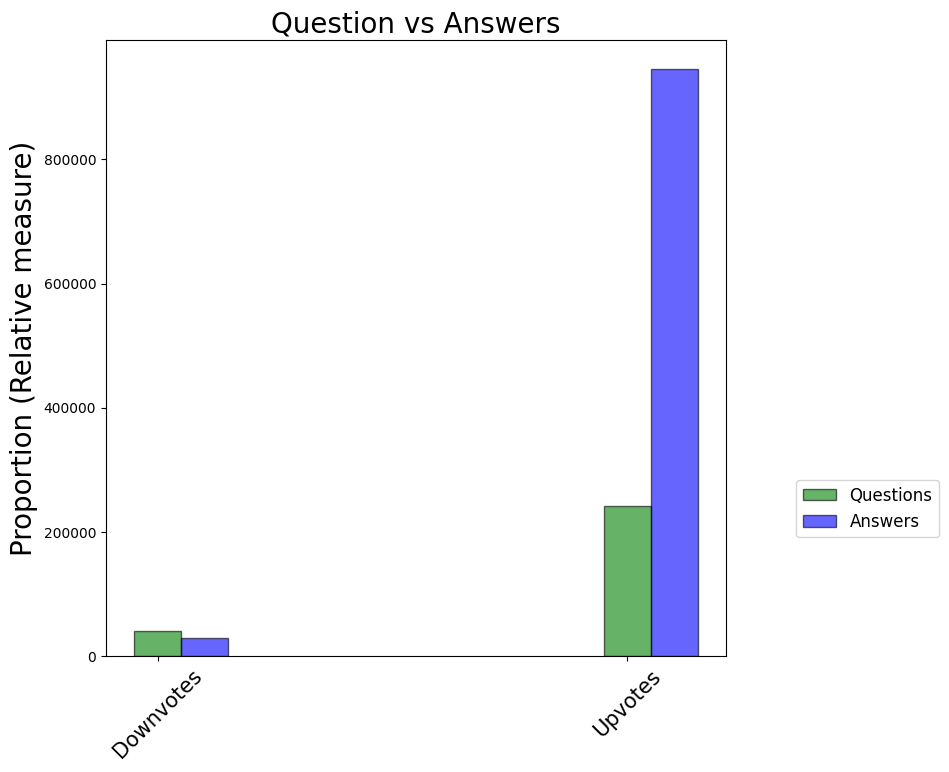

In [62]:
# Create a bar plot to compare downvotes and upvotes for questions and answers
plt.figure(figsize=(8, 8))
index_questions = [1, 2]
index_answers = [1.1, 2.1]

answer_votes = [A_downvotes, A_upvotes]
question_votes = [Q_downvotes, Q_upvotes]

plt.xticks([1, 2], ["Downvotes", "Upvotes"], rotation=45, fontsize=15)
plt.bar(index_questions, question_votes, label='Questions', color='green', alpha=0.6, edgecolor='k', width=0.1)
plt.bar(index_answers, answer_votes, label='Answers', color='blue', alpha=0.6, edgecolor='k', width=0.1)
plt.ylabel('Proportion (Relative measure)', fontsize=20)
plt.legend(loc=0, bbox_to_anchor=(1.1, 0.3), fontsize='large')
plt.title('Question vs Answers', fontsize=20)

- ### Conclusion - There is a higher % of downvotes to questions than to answers.

### 3.3 Q&A Scores by 'CreationYear' - when question was posted

In [63]:
# Extract the year from the 'CreationYear' column
df_no_outliers['CreationYear'] = pd.DatetimeIndex(df_no_outliers['CreationYear']).year

In [64]:
df_no_outliers['CreationYear'].value_counts()

CreationYear
2013    289844
2014    283389
2015    275448
2012    245624
2016    215249
2011    191641
2010    119310
2009     68982
2008     11945
Name: count, dtype: int64

In [65]:
# Set the random seed for reproducibility
np.random.seed(2018)

# Reset the index of the DataFrame
df_no_outliers.reset_index(drop=True, inplace=True)

# Randomly sample 10,000 rows from the DataFrame without replacement
sample = np.random.choice(df_no_outliers.shape[0], 10000, replace=False)
df_subset = df_no_outliers.loc[sample]

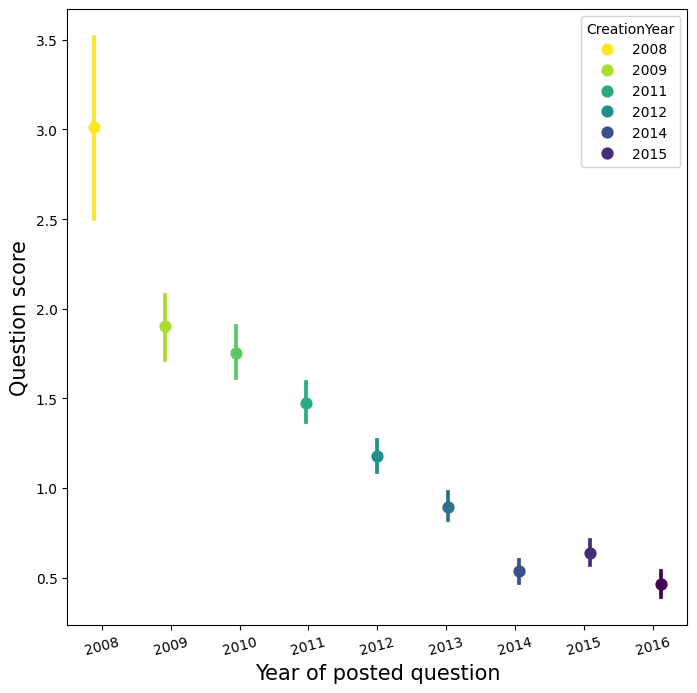

In [66]:
# Create a point plot to visualize the relationship between question scores and the year of posting
plt.figure(figsize=(8, 8))

# Plot the data
ax = sns.pointplot(data=df_subset, x='CreationYear', y='Q_Score', hue='CreationYear', dodge=True, linestyles="", palette='viridis_r')

# Customize the plot
plt.xticks(rotation=15)
plt.ylabel('Question score', fontsize=15)
plt.xlabel('Year of posted question', fontsize=15)
plt.show()


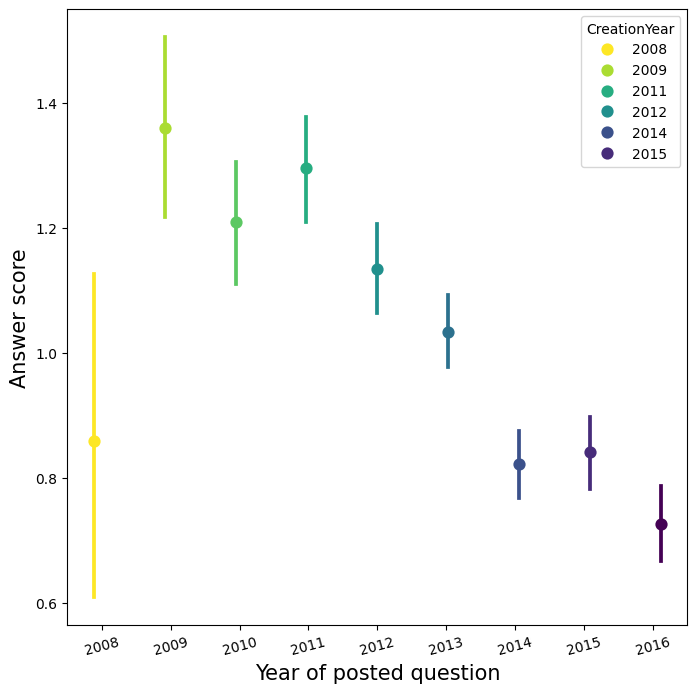

In [67]:
# Create a point plot to visualize the relationship between answer scores and the year of posting
plt.figure(figsize=(8, 8))

# Plot the data
ax = sns.pointplot(data=df_subset, x='CreationYear', y='A_Score', hue='CreationYear', dodge=True, linestyles="", palette='viridis_r')

# Customize the plot
plt.xticks(rotation=15)
plt.ylabel('Answer score', fontsize=15)
plt.xlabel('Year of posted question', fontsize=15)
plt.show()

 ***Conclusion*** : Over time, the average scores for both questions and answers have decreased. This could be attributed to changes in the scoring mechanism or a decline in the initial enthusiasm of the developer community to actively upvote questions and answers.

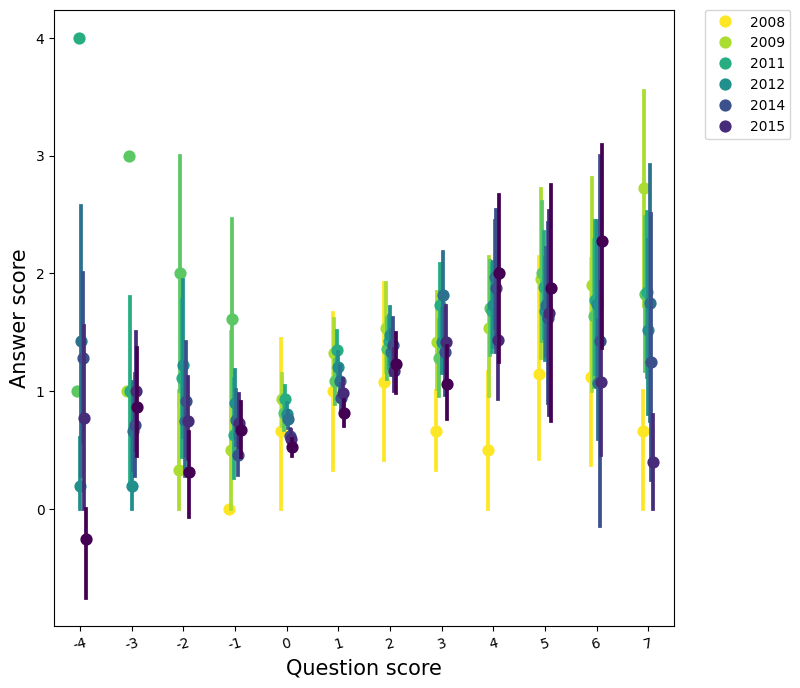

In [68]:
# Create a point plot to visualize the relationship between question scores and answer scores
plt.figure(figsize=(8, 8))

# Plot the data
ax = sns.pointplot(data=df_subset, x='Q_Score', y='A_Score', hue='CreationYear', dodge=True, linestyles="", palette='viridis_r')

# Customize the plot
plt.xticks(rotation=15)
plt.ylabel('Answer score', fontsize=15)
plt.xlabel('Question score', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### 3.4 Most popular Question Title - answered most number of times

In [69]:
# Calculate the count of top 20 questions
top_20_question_count = df_no_outliers['Title'].value_counts().head(20)

# Create a DataFrame to store the results
top_20_question_df = pd.DataFrame(data=top_20_question_count).reset_index()
top_20_question_df.columns = ['Question', 'Count']

# Display the top 20 questions and their counts
top_20_question_df

,Question,Count
0,regular express,35
1,operator overloading c,30
2,input string correct format,27
3,highest salary depart,23
4,interview questions challenging beginn,23
5,new coding languag,23
6,jquery selector problem,21
7,javascript valid,21
8,expect javascript become widely used outside b...,19
9,parse xml using java,19


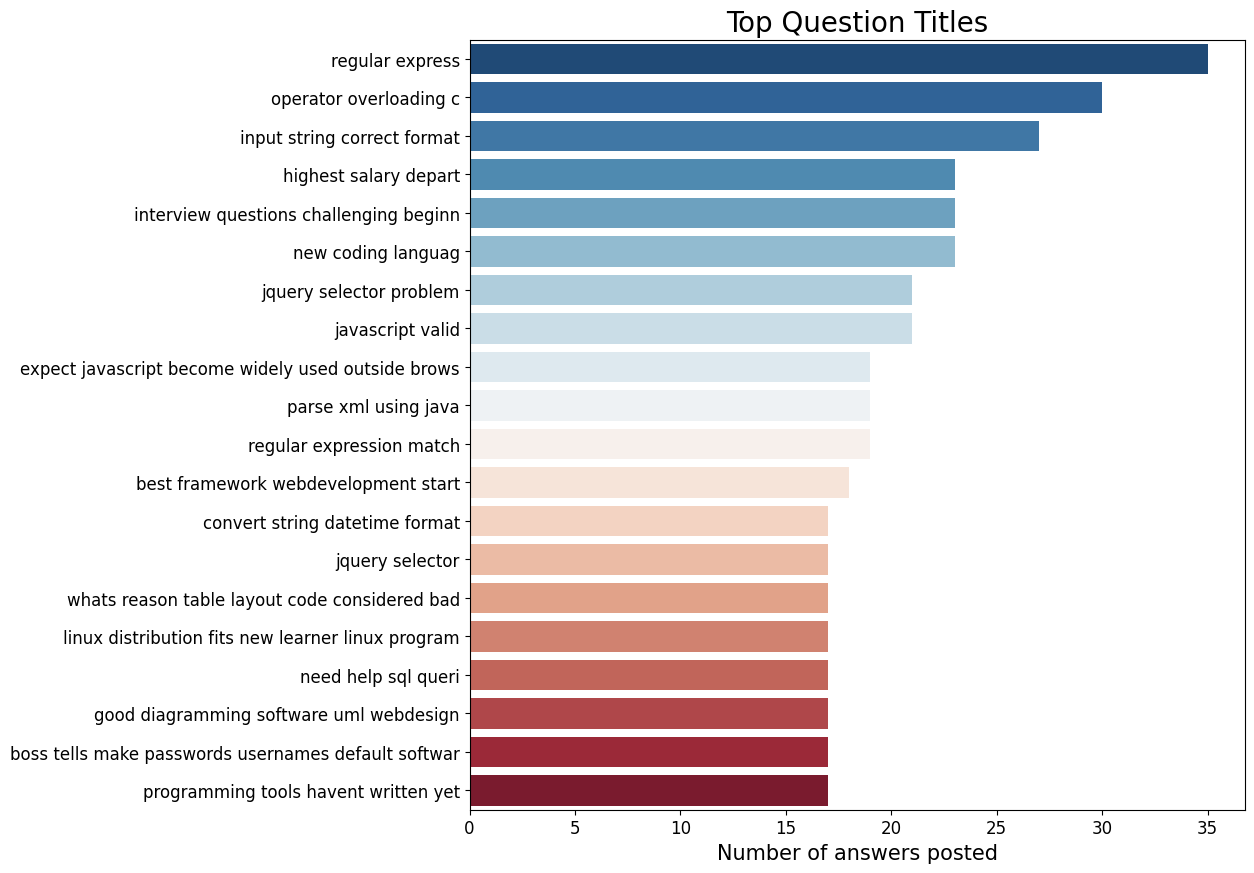

In [70]:
# Create a bar plot to visualize the top question titles and their counts
from textwrap import wrap
f, ax = plt.subplots(figsize=(10, 10))

# Extract the question titles and counts
names_top20 = list(top_20_question_df.Question)
values_top20 = list(top_20_question_df.Count)

# Plot the data
ax = sns.barplot(x=values_top20, y=names_top20, palette="RdBu_r", ax=ax)

# Customize the plot
ax.set_title("Top Question Titles", fontsize=20)
ax.set_xticks([0, 5, 10, 15, 20, 25, 30, 35])
ax.set_xlabel('Number of answers posted', fontsize=15)
ax.tick_params(labelsize=12)

### 3.5 Most popular Questions - based on maximum upvotes

In [71]:
# Filter the top 20 upvoted questions
top_20_upvoted_questions = df_no_outliers_unique_q[df_no_outliers_unique_q['Q_Score'] > 0].sort_values(by=['Q_Score'], ascending=False).head(20)

# Create a DataFrame to store the results
top_20_upvoted_question_df = pd.DataFrame(data=top_20_upvoted_questions).drop(columns=['A_Score', 'Id', 'CreationYear', 'Q_Body', 'Tag', 'A_Body']).reset_index()

# Display the title and score of the top 20 upvoted questions
top_20_upvoted_question_df[['Title', 'Q_Score']]

,Title,Q_Score
0,list currently running process golang,7
1,common way dealing libraries dependencies buil...,7
2,spring security http basic authent,7
3,resqueweb fails start 500 server error,7
4,many runs java program need warmup jvm,7
5,naming restrictions variables java,7
6,saving coredata context background thread,7
7,angularjs orderby doesnt work orderbyproperty ...,7
8,c template call function pointer typ,7
9,using two different python distribut,7


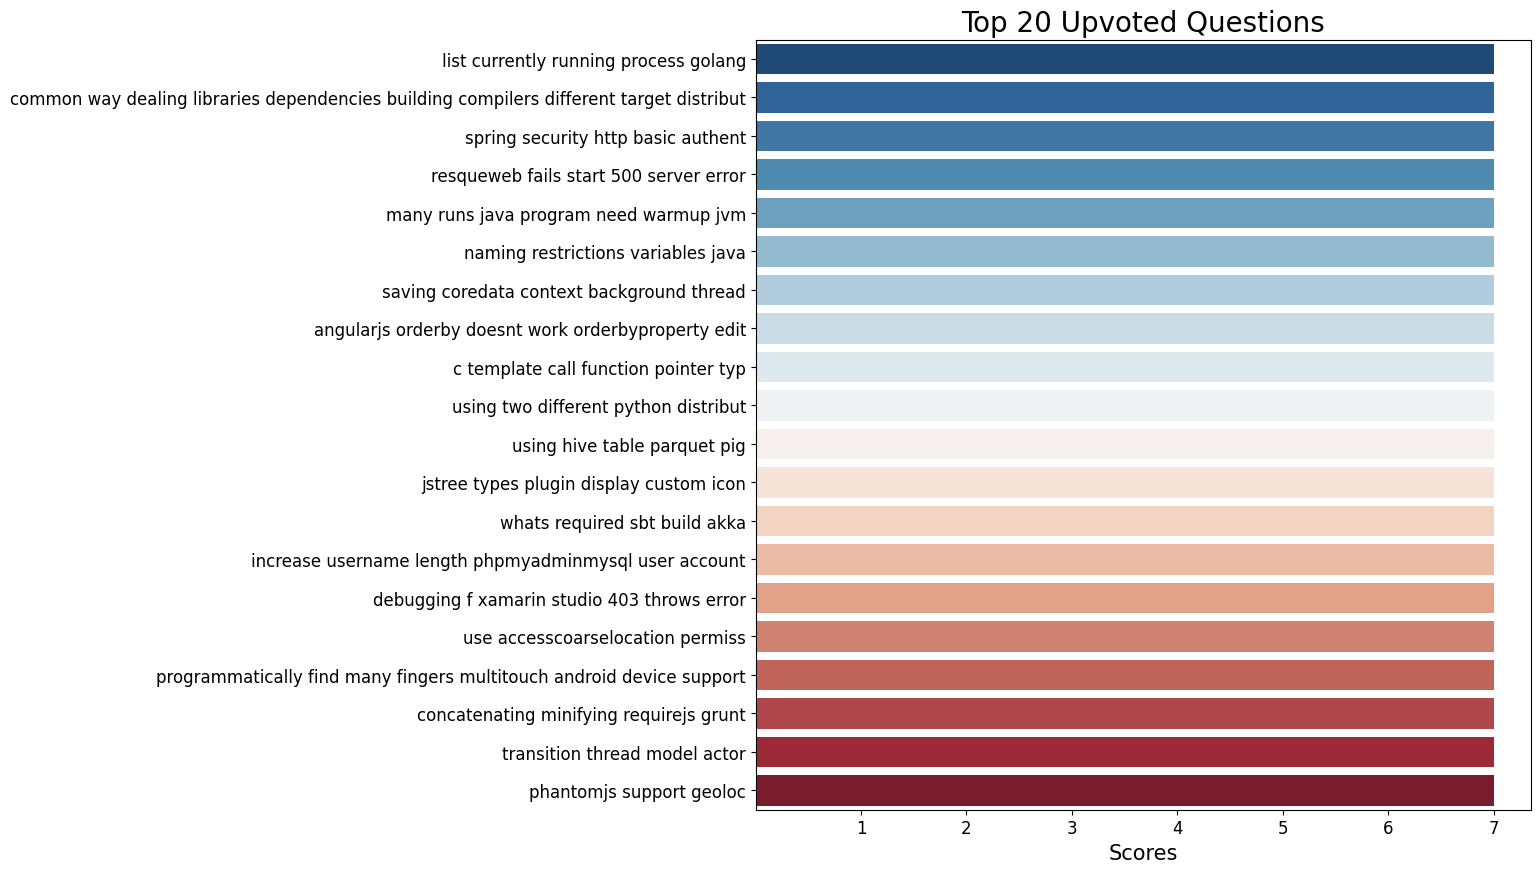

In [72]:
# Create a bar plot to visualize the top 20 upvoted questions
from textwrap import wrap
f, ax = plt.subplots(figsize=(10, 10))

# Extract the question titles and scores
names_top20_q_upvotes = list(top_20_upvoted_question_df.Title)
values_top20_q_upvotes = list(top_20_upvoted_question_df.Q_Score)

# Plot the data
ax = sns.barplot(x=values_top20_q_upvotes, y=names_top20_q_upvotes, palette="RdBu_r", ax=ax)

# Customize the plot
ax.set_title("Top 20 Upvoted Questions", fontsize=20)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xlabel('Scores', fontsize=15)
ax.tick_params(labelsize=12)

### 3.6 Most popular Answer - based on maximum upvotes

- Perform some text processing on the answers before plotting the chart

In [73]:
# Remove HTML tags from the 'A_Body' column
df_no_outliers['A_Body'] = df_no_outliers['A_Body'].apply(lambda x: re.sub('<[^<]+?>', '', x))

# Display the first 5 rows of the 'A_Body' column
df_no_outliers['A_Body'].head(5)

0    Validation should be captured separately from ...
1    From the perspective of having the most mainta...
2    It depends.\r\n\r\nGenerally, code should fail...
3    You might wanna check out Domain Driven Design...
4    You didn't mention for what OS, but the WMI Re...
Name: A_Body, dtype: object

In [74]:
# Convert the 'A_Body' column to lowercase
df_no_outliers['A_Body'] = df_no_outliers['A_Body'].str.lower()

# Remove punctuation from the 'A_Body' column
df_no_outliers['A_Body'] = df_no_outliers['A_Body'].apply(remove_punctuation)

# Clean the text in the 'A_Body' column
df_no_outliers['A_Body'] = df_no_outliers['A_Body'].apply(lambda x: clean_text(x))

In [75]:
# Filter the top 20 upvoted answers
top_20_upvoted_answers = df_no_outliers[df_no_outliers['A_Score'] > 0].sort_values(by=['A_Score'], ascending=False).head(20)

# Create a DataFrame to store the results
top_20_upvoted_answers_df = pd.DataFrame(data=top_20_upvoted_answers).drop(columns=['Q_Score', 'Id', 'Title', 'CreationYear', 'Q_Body', 'Tag']).reset_index()

# Display the answer body and score of the top 20 upvoted answers
top_20_upvoted_answers_df[['A_Body', 'A_Score']]

,A_Body,A_Score
0,if you used explicit return it will work def f...,5
1,because ul element has default margin you can ...,5
2,michaels most excellent solution can yet be sl...,5
3,if your case variable is unique you can certai...,5
4,heres an alternative using mapply gt mapplyin ...,5
5,you can use rle it computes the lengths and va...,5
6,you can style scrollbars in internet explorer ...,5
7,the following is the clearest solution i could...,5
8,from the mozilla article on synchronous and as...,5
9,in your subclass you shadow points x and y var...,5


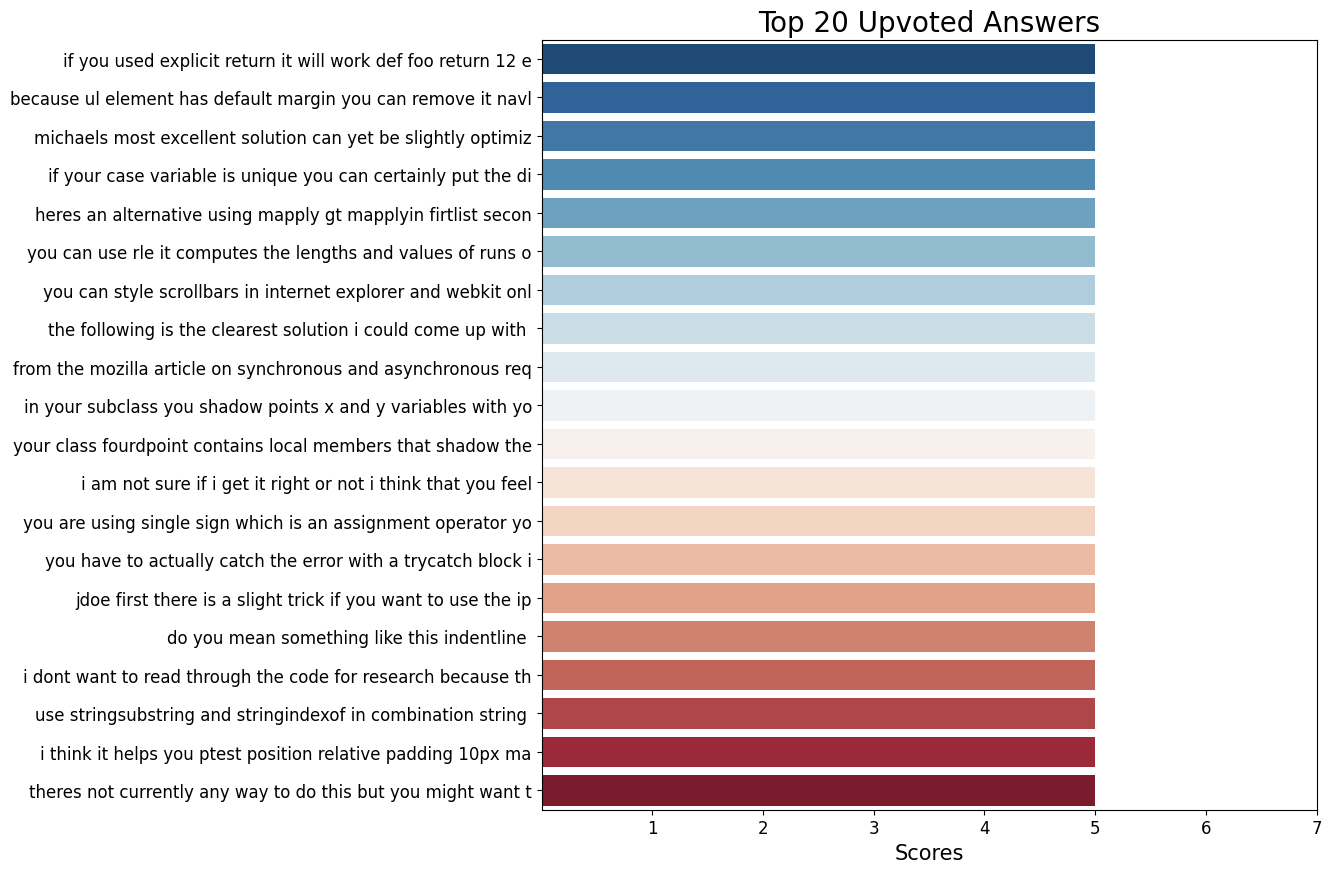

In [76]:
# Create a bar plot to visualize the top 20 upvoted answers
from textwrap import wrap
f, ax = plt.subplots(figsize=(10, 10))

# Extract the answer bodies (truncated to 60 characters) and scores
names_top20_a_upvotes = list(top_20_upvoted_answers_df.A_Body.str[:60])
values_top20_a_upvotes = list(top_20_upvoted_answers_df.A_Score)

# Plot the data
ax = sns.barplot(x=values_top20_a_upvotes, y=names_top20_a_upvotes, palette="RdBu_r", ax=ax)

# Customize the plot
ax.set_title("Top 20 Upvoted Answers", fontsize=20)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xlabel('Scores', fontsize=15)
ax.tick_params(labelsize=12)

- Word cloud for 'Tags'
- Word cloud for 'Questions (Title AND Body)'
- Word cloud for 'Answers'


In [77]:
# Create a word cloud visualization
from wordcloud import WordCloud, STOPWORDS

# Set stopwords (common words to exclude)
stopwords = set(STOPWORDS)

def show_wordcloud(data, title=None):
    # Generate the word cloud
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1  # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    # Create the plot
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


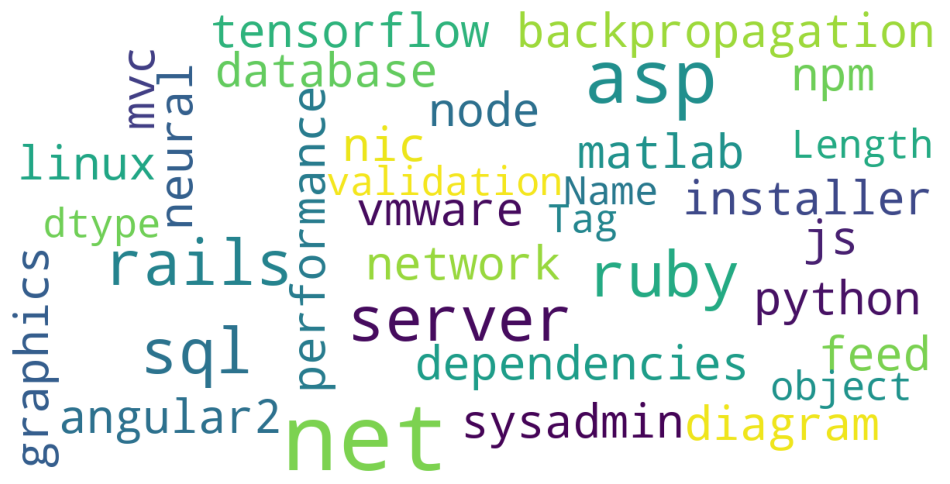

In [78]:
show_wordcloud(df_no_outliers_unique_q['Tag'])

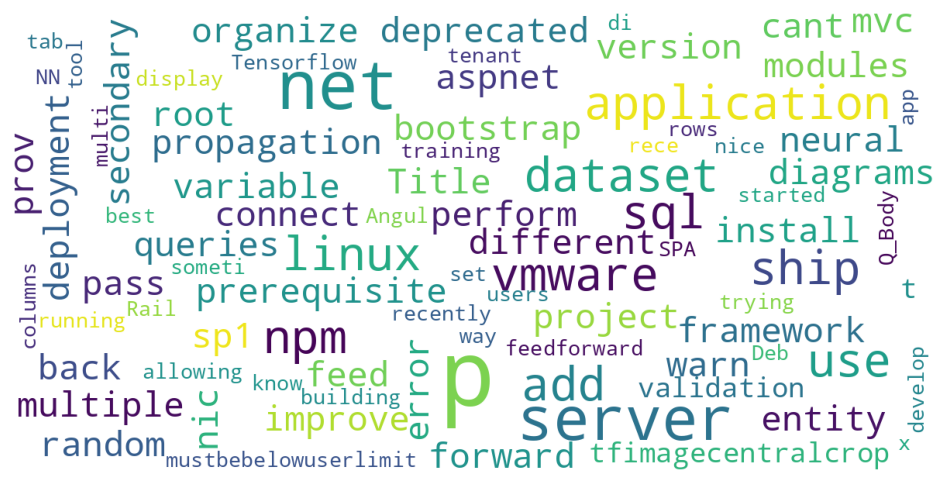

In [79]:
show_wordcloud(df_no_outliers_unique_q[['Title','Q_Body']])

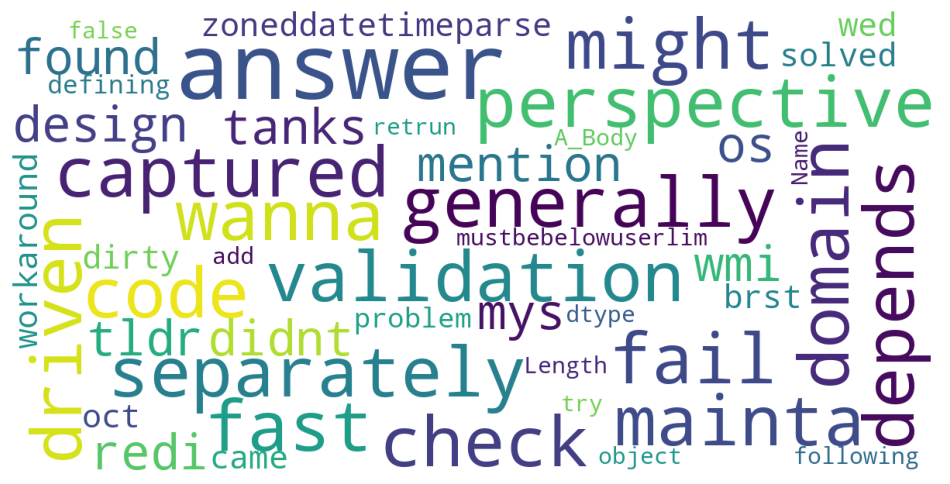

In [80]:
show_wordcloud(df_no_outliers['A_Body'])

### 3.7 Trigrams of Question Titles that were ```upvoted``` and ```downvoted```

In [81]:
# Filter questions with downvotes
df_downvotes = df_no_outliers_unique_q[df_no_outliers_unique_q['Q_Score'] < 0]

# Filter questions with upvotes
df_upvotes = df_no_outliers_unique_q[df_no_outliers_unique_q['Q_Score'] > 0]

In [82]:
df_downvotes['Title'].sample(5)

1991711    unable delete 90 days older data mysql via she...
1709576           retrieve selected checkboxes array control
1474972            share image instagram via intent json url
1880145               correlation matrix huge dataset python
1307145                     generate cuda program dlls linux
Name: Title, dtype: object

In [83]:
df_upvotes['Title'].sample(5)

1986334    hide markers embed google map clicking aspnet mvc
850205                               android external storag
1729620                         javascript regex foreign nam
1123815             sql incremential count x left outer join
1828017                         populate multiple level work
Name: Title, dtype: object

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



                       Frequency
Word                            
can not find                 202
google app engine            186
sql server 2008              176
visual studio 2010           173
mac os x                     147
windows phone 8              128
can not read                 121
google maps api              120
visual studio 2015           118
visual studio 2013           104
error can not                103
visual studio 2012           101
can not get                   94
not read property             93
windows phone 7               91
google app engin              83
can not access                80
windows phone 81              79
sql server 2005               78
internal server error         72


Text(0.5, 1.0, 'Upvoted Questions: Trigram Word Frequency')

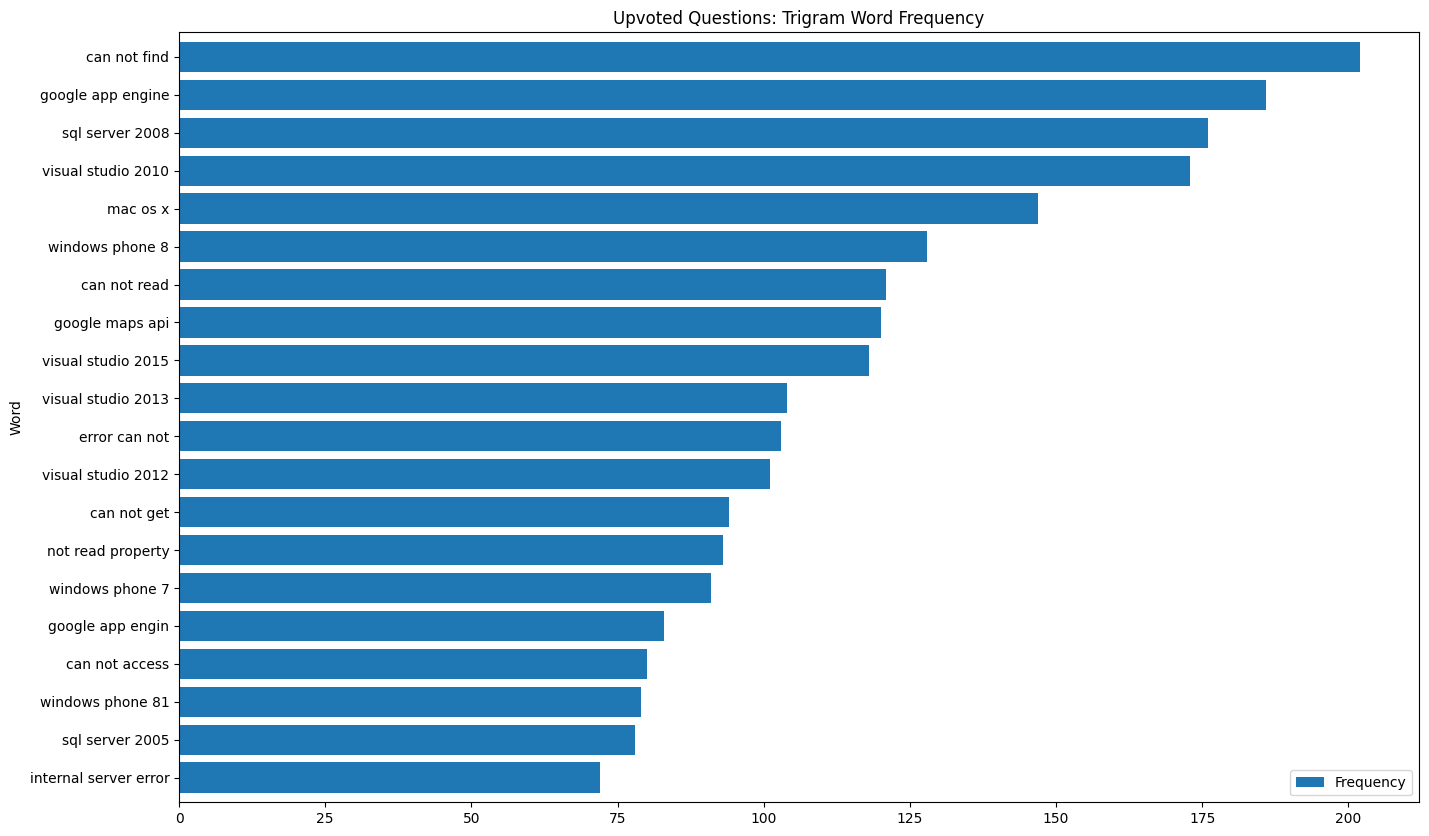

In [84]:
# Calculate trigrams for upvoted question titles
from collections import Counter

# Concatenate all upvoted question titles
upvoted_questions = (df_upvotes.Title.str.cat(sep=' '))

# Tokenize the words
words_up_questions = nltk.tokenize.word_tokenize(upvoted_questions)

# Create trigrams
trigrm_up = list(nltk.trigrams(words_up_questions))
print(trigrm_up)

# Calculate word frequencies for trigrams
word_dist_up = nltk.FreqDist([' '.join(x) for x in trigrm_up])
trigram_up_question_words = pd.DataFrame(word_dist_up.most_common(20), columns=['Word', 'Frequency']).set_index('Word').sort_values(by=['Frequency'], ascending=True)
print(trigram_up_question_words.sort_values(by=['Frequency'], ascending=False))

# Create a horizontal bar plot
trigram_up_question_words.plot.barh(rot=0, figsize=(16, 10), width=0.8)
plt.title('Upvoted Questions: Trigram Word Frequency')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Text(0.5, 1.0, 'Downvoted Questions: Trigram Word Frequency')

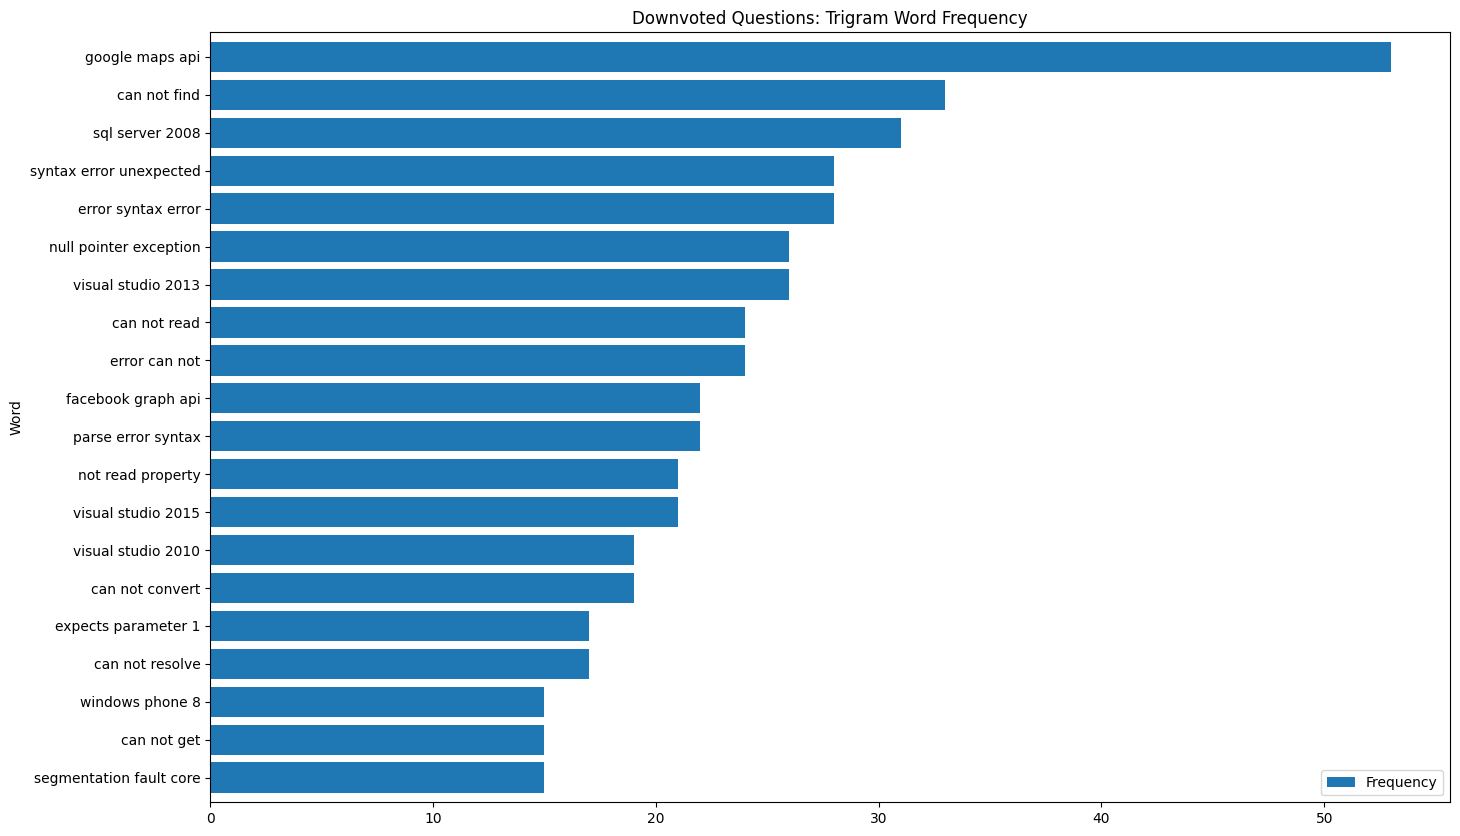

In [85]:
# Concatenate all downvoted question titles
downvoted_questions = (df_downvotes.Title
                       .str.cat(sep=' '))

# Tokenize the words
words_dw_questions = nltk.tokenize.word_tokenize(downvoted_questions)

# Create trigrams
trigrm_dw = list(nltk.trigrams(words_dw_questions))
print(trigrm_dw)

# Calculate word frequencies for trigrams
word_dist_dw = nltk.FreqDist([' '.join(x) for x in trigrm_dw])
trigram_dw_question_words = pd.DataFrame(word_dist_dw.most_common(20),
                                         columns=['Word', 'Frequency']).set_index('Word').sort_values(by=['Frequency'], ascending=True)
print(trigram_dw_question_words.sort_values(by=['Frequency'], ascending=False))

# Create a horizontal bar plot
trigram_dw_question_words.plot.barh(rot=0, figsize=(16, 10), width=0.8)
plt.title('Downvoted Questions: Trigram Word Frequency')

### 3.7 Trigrams of Answers that were ```upvoted``` and ```downvoted```

In [86]:
# Create a DataFrame containing downvoted answers
df_ans_downvotes = df_no_outliers[df_no_outliers['A_Score'] < 0]

# Create a DataFrame containing upvoted answers
df_ans_upvotes = df_no_outliers[df_no_outliers['A_Score'] > 0]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



                     Frequency
Word                          
you need to                815
you want to                683
you can use                668
if you want                468
you have to                315
you can do                 300
be able to                 272
something like this        249
if you have                245
if you are                 235
there is no                232
you are using              184
there is a                 181
this is a                  179
in this case               178
you have a                 176
to get the                 170
to use the                 166
you could use              162
0 i lt                     158


Text(0.5, 1.0, 'Upvoted Answers: Trigram Word Frequency')

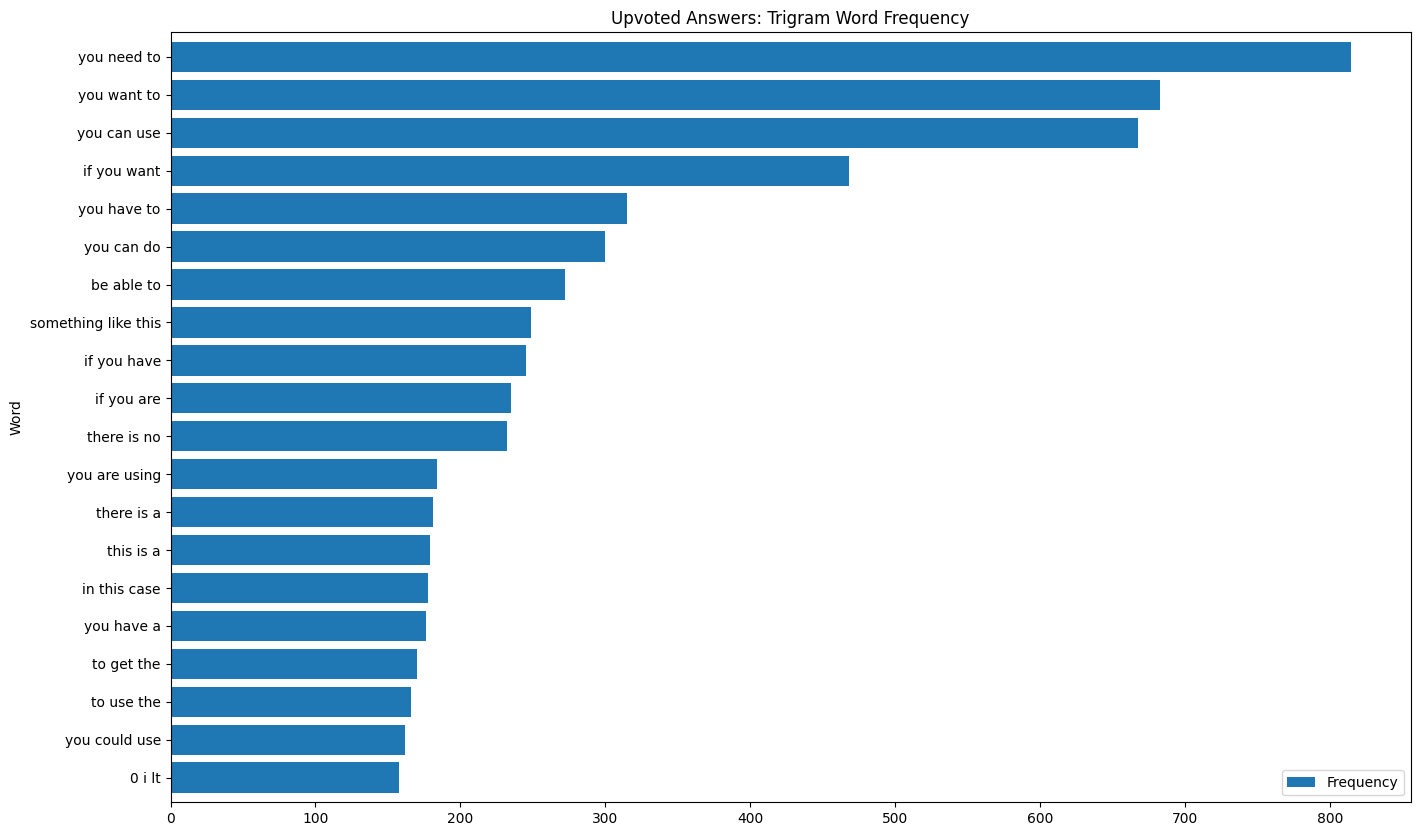

In [87]:
# Set a random seed for reproducibility
np.random.seed(2018)

# Reset the index of the DataFrame and create a subset of 10,000 samples without replacement
df_ans_upvotes.reset_index(drop=True, inplace=True)
sample = np.random.choice(df_ans_upvotes.shape[0], 10000, replace=False) 
df_ans_upvotes_subset = df_ans_upvotes.loc[sample]

# Concatenate all upvoted answer bodies
upvoted_answers = (df_ans_upvotes_subset.A_Body.str.cat(sep=' '))

# Tokenize the words
words_up_answers = nltk.tokenize.word_tokenize(upvoted_answers)

# Create trigrams
trigrm_ans_up = list(nltk.trigrams(words_up_answers))
print(trigrm_ans_up)

# Calculate word frequencies for trigrams
ans_word_dist_up = nltk.FreqDist([' '.join(x) for x in trigrm_ans_up])
trigram_up_answer_words = pd.DataFrame(ans_word_dist_up.most_common(20),
                                       columns=['Word', 'Frequency']).set_index('Word').sort_values(by=['Frequency'], ascending=True)
print(trigram_up_answer_words.sort_values(by=['Frequency'], ascending=False))

# Create a horizontal bar plot
trigram_up_answer_words.plot.barh(rot=0, figsize=(16, 10), width=0.8)
plt.title('Upvoted Answers: Trigram Word Frequency')


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



                      Frequency
Word                           
you need to                 516
you can use                 501
you want to                 501
if you want                 340
you have to                 266
you can do                  208
if you are                  190
something like this         188
0 i lt                      159
i 0 i                       154
there is no                 148
if you have                 146
you are using               142
be able to                  135
then you can                131
there is a                  129
what you want               127
i think you                 125
override public void        123
to get the                  117


Text(0.5, 1.0, 'Downvoted Answers: Trigram Word Frequency')

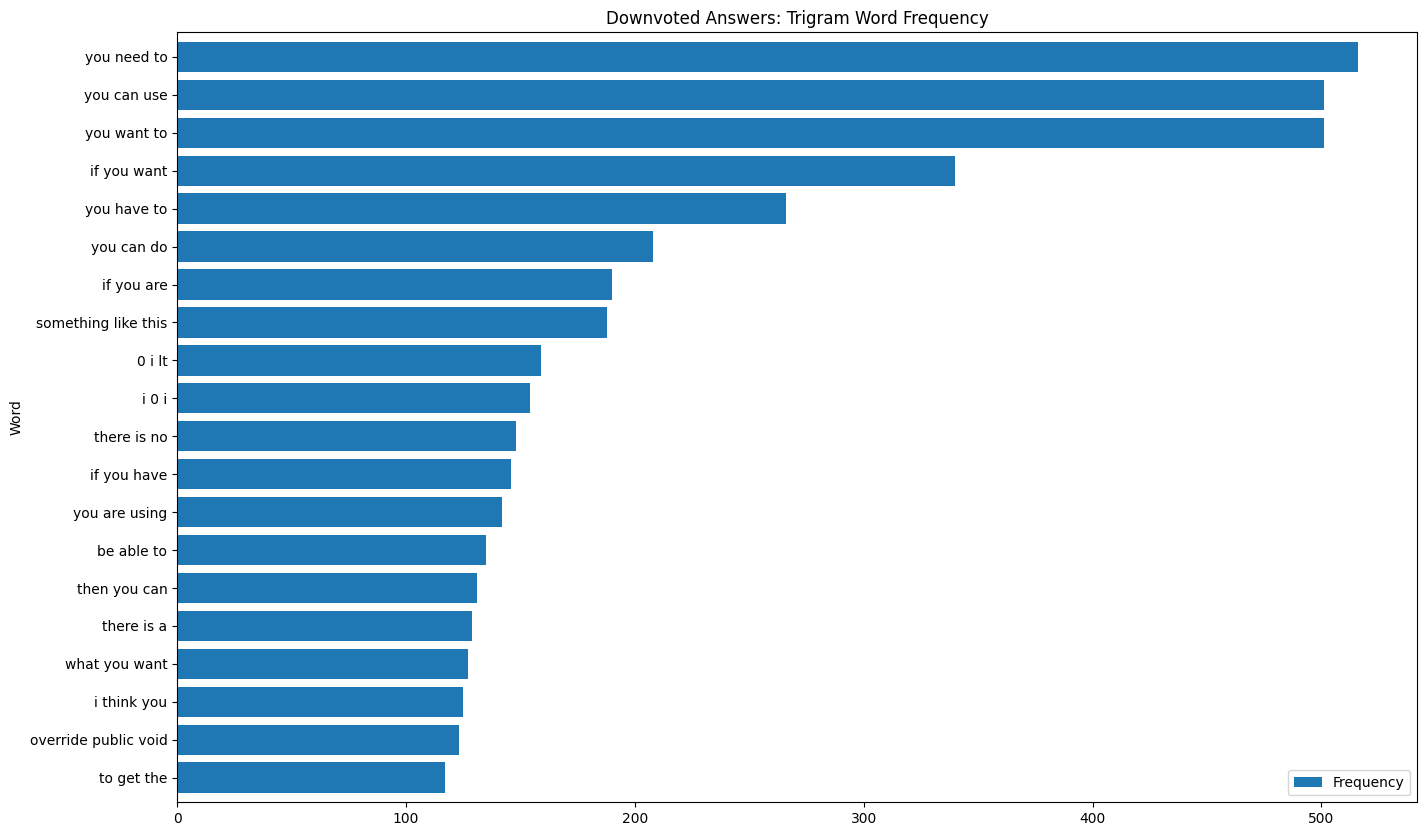

In [88]:
# Set a random seed for reproducibility
np.random.seed(2018)

# Reset the index of the DataFrame and create a subset of 10,000 samples without replacement
df_ans_downvotes.reset_index(drop=True, inplace=True)
sample = np.random.choice(df_ans_downvotes.shape[0], 10000, replace=False) 
df_ans_downvotes_subset = df_ans_downvotes.loc[sample]

# Concatenate all downvoted answer bodies
downvoted_answers = (df_ans_downvotes_subset.A_Body.str.cat(sep=' '))

# Tokenize the words
words_dw_answers = nltk.tokenize.word_tokenize(downvoted_answers)

# Create trigrams
trigrm_ans_dw = list(nltk.trigrams(words_dw_answers))
print(trigrm_ans_dw)

# Calculate word frequencies for trigrams
ans_word_dist_dw = nltk.FreqDist([' '.join(x) for x in trigrm_ans_dw])
trigram_dw_answer_words = pd.DataFrame(ans_word_dist_dw.most_common(20),
                                       columns=['Word', 'Frequency']).set_index('Word').sort_values(by=['Frequency'], ascending=True)
print(trigram_dw_answer_words.sort_values(by=['Frequency'], ascending=False))

# Create a horizontal bar plot
trigram_dw_answer_words.plot.barh(rot=0, figsize=(16, 10), width=0.8)
plt.title('Downvoted Answers: Trigram Word Frequency')

In [89]:
df_no_outliers.shape[0]

1701432

#### Continuing from the previous step where only the 'Title' text was processed, we need to perform further text preprocessing before handling missing values. Note that for this project, stemming and stop word filtering are not applied to the 'Q_Body' in this notebook due to recurring errors.

In [90]:
# Remove stop words and perform stemming on the 'A_Body' column in the DataFrame.

df_no_outliers['A_Body'] = df_no_outliers['A_Body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_no_outliers['A_Body'] = df_no_outliers['A_Body'].apply(lambda x: stemmer.stem(x))

In [91]:
# Clean the 'Q_Body' column by converting text to lowercase, removing punctuation and HTML tags, 
# and applying text cleaning functions.

# Preprocessing steps for the 'Q_Body' column:
# 1. Convert all text to lowercase
df_no_outliers['Q_Body'] = df_no_outliers['Q_Body'].str.lower()

# 2. Remove punctuation from the text
df_no_outliers['Q_Body'] = df_no_outliers['Q_Body'].apply(remove_punctuation)

# 3. Remove HTML tags (e.g., <p>, <a>, etc.) from the text
df_no_outliers['Q_Body'] = df_no_outliers['Q_Body'].apply(lambda x: re.sub('<[^<]+?>', '', x))

# 4. Apply additional text cleaning (e.g., removing special characters, stopwords, etc.)
df_no_outliers['Q_Body'] = df_no_outliers['Q_Body'].apply(lambda x: clean_text(x))


In [92]:
print(df_no_outliers.columns, df_no_outliers.Id.nunique())

Index(['Q_Score', 'A_Score', 'Id', 'CreationYear', 'Title', 'Q_Body', 'Tag',
       'A_Body'],
      dtype='object') 1013820


In [93]:
# Reorder the columns in the DataFrame based on the specified order
columnsTitles = ['Id', 'Title', 'Tag', 'Q_Body', 'Q_Score', 'A_Body', 'A_Score']
df_cleansed = df_no_outliers.reindex(columns=columnsTitles)

In [94]:
df_cleansed.columns

Index(['Id', 'Title', 'Tag', 'Q_Body', 'Q_Score', 'A_Body', 'A_Score'], dtype='object')

In [95]:
# Calculate statistics for the 'Q_Body' and 'A_Body' column lengths:
# - 25th percentile (Q1)
# - 75th percentile (Q3)
# - Interquartile range (IQR)

# For 'Q_Body':
Q_25perc = df_cleansed['Q_Body'].str.len().quantile(0.25)
Q_75perc = df_cleansed['Q_Body'].str.len().quantile(0.75)
Q_IQR = Q_75perc - Q_25perc

# For 'A_Body':
A_25perc = df_cleansed['A_Body'].str.len().quantile(0.25)
A_75perc = df_cleansed['A_Body'].str.len().quantile(0.75)
A_IQR = A_75perc - A_25perc

# Print mean, median, and IQR for both columns
print("Q_Body - Mean:", df_cleansed['Q_Body'].str.len().mean(), "Median:", df_cleansed['Q_Body'].str.len().median(), "IQR:", Q_IQR)
print("A_Body - Mean:", df_cleansed['A_Body'].str.len().mean(), "Median:", df_cleansed['A_Body'].str.len().median(), "IQR:", A_IQR)

Q_Body - Mean: 1029.546890501648 Median: 707.0 IQR: 766.0
A_Body - Mean: 391.8369485233615 Median: 258.0 IQR: 328.0


#### Filtering out question and answer bodies with a length less than 100 characters could be acceptable. We are primarily interested in Q&A content that provides technical descriptions of the problem and potential solutions.

In [96]:
# Filter out rows where the 'Q_Body' and 'A_Body' lengths are less than 100 characters
df_cleansed = df_no_outliers[df_no_outliers['Q_Body'].str.len() >= 100]
df_cleansed = df_no_outliers[df_no_outliers['A_Body'].str.len() >= 100]

# Get the total number of remaining rows after filtering
total_rows = df_cleansed.shape[0]

In [97]:
df_cleansed.shape[0]

1455901

In [98]:
df_cleansed.head()

,Q_Score,A_Score,Id,CreationYear,Title,Q_Body,Tag,A_Body
0,7,1,2750,2008,data verifications gettersetter elsewher,pim wondering if its a good idea to make stron...,"optimization, setter, getter, verification",validation captured separately getters setters...
1,7,3,2750,2008,data verifications gettersetter elsewher,pim wondering if its a good idea to make stron...,"optimization, setter, getter, verification",perspective maintainable code think much valid...
2,7,3,2750,2008,data verifications gettersetter elsewher,pim wondering if its a good idea to make stron...,"optimization, setter, getter, verification",depends generally code fail fast value set mul...
3,7,1,2750,2008,data verifications gettersetter elsewher,pim wondering if its a good idea to make stron...,"optimization, setter, getter, verification",might wanna check domain driven design eric ev...
4,3,1,3790,2008,wmi redistributable packag,pive been working on a project that accesses t...,"windows, 64bit, wmi",didnt mention os wmi redistributable component...


In [99]:
df_cleansed.to_csv('..\StackoverflowTagClassificationDeck\data\Stackoverflow_cleansed.csv', index=False)